In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from allison.nn import Relu,Linear
from allison.nn import SGDMomentum
from allison.nn import Tensor,no_grad
from allison.nn import NeuralNetwork
from allison.nn import CrossEntropyLoss
from allison.utils.metrics import confusion_matrix,classification_report
from allison.datasets import train_test_split
import pandas as pd
import joblib
import seaborn as sns

# Datos

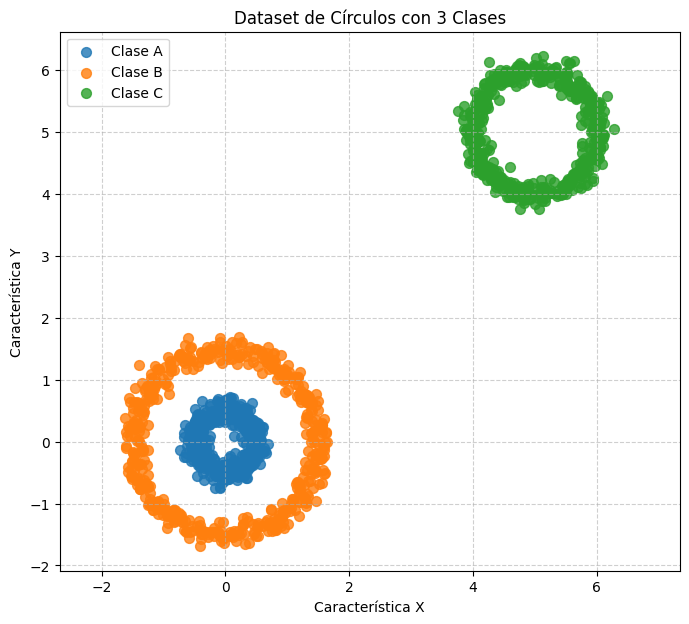

In [2]:
r1 = 0.5  
r2 = 1.5  
r3 = 1  

num_points = 500
thetas = np.linspace(0, 2 * np.pi, num_points) 


x1 = r1 * np.cos(thetas) + 0.1 * np.random.randn(num_points)
y1 = r1 * np.sin(thetas) + 0.1 * np.random.randn(num_points)


x2 = r2 * np.cos(thetas) + 0.1 * np.random.randn(num_points)
y2 = r2 * np.sin(thetas) + 0.1 * np.random.randn(num_points)


x3 = 5 + r3 * np.cos(thetas) + 0.1 * np.random.randn(num_points)
y3 = 5 + r3 * np.sin(thetas) + 0.1 * np.random.randn(num_points)


plt.figure(figsize=(8, 7)) 


plt.scatter(x1, y1, s=50, label="Clase A", alpha=0.8) # Puntos de la Clase A
plt.scatter(x2, y2, s=50, label="Clase B", alpha=0.8) # Puntos de la Clase B
plt.scatter(x3, y3, s=50, label="Clase C", alpha=0.8) # Puntos de la Clase C

plt.xlabel("Característica X") 
plt.ylabel("Característica Y")
plt.title("Dataset de Círculos con 3 Clases")
plt.legend() 
plt.grid(True, linestyle='--', alpha=0.6)
plt.axis('equal')
plt.show() 


In [3]:
df = pd.DataFrame(
    {"x": x1.tolist()+x2.tolist()+x3.tolist(),
    "y": y1.tolist()+y2.tolist()+y3.tolist(),
    "labels":['A' for _ in range(num_points)]+['B' for _ in range(num_points)]+['C' for _ in range(num_points)]
    })

labels = df["labels"].unique()
labels2id = {label: i for i, label in enumerate(labels)}
id2labels = {v: k for k, v in labels2id.items()}

df["labels"] = df["labels"].map(labels2id)
df.head()

,x,y,labels
0,0.444596,0.149158,0
1,0.337012,0.158287,0
2,0.475696,-0.122340,0
3,0.515607,-0.011357,0
4,0.553092,0.050604,0


In [4]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

X_train = Tensor(df_train[["x","y"]].values)
Y_train = Tensor(df_train[["labels"]].values)

X_test = Tensor(df_test[["x","y"]].values)
Y_test = Tensor(df_test[["labels"]].values)

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")


X_train shape: (1200, 2)
Y_train shape: (1200, 1)
X_test shape: (300, 2)
Y_test shape: (300, 1)


In [5]:
class Network(NeuralNetwork):
    def __init__(self):
        super().__init__()
        self.fc1 = Linear(2, 4)
        self.relu = Relu()
        self.fc2 = Linear(4, 4)
        self.fc3 = Linear(4, 3)

    def forward(self, x: Tensor) -> Tensor:
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


net = Network()



criterion = CrossEntropyLoss()
optimizer = SGDMomentum(net.parameters(), learning_rate=1e-3, momentum=0.9)

# Training

In [6]:
# Bucle de entrenamiento mejorado
for epoch in range(10000 + 1):
    out = net(X_train)
    loss = criterion(Y_train, out)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        acc_train = np.mean(out.data.argmax(axis=1, keepdims=True) == Y_train.data)
        with no_grad():
            out = net(X_test)
            acc_test = np.mean(out.data.argmax(axis=1, keepdims=True) == Y_test.data)

        # Usamos una f-string para formatear y alinear la salida
        print(f"Epoch {epoch:5d} | Loss: {loss.data:.4f} | Acc Train: {acc_train*100:.2f}% | Acc Test: {acc_test*100:.2f}%")

        if acc_test >= 0.90:  # Mejoramos el criterio de parada
            print(f"Entrenamiento completado en {epoch} epochs!")
            break


Epoch     0 | Loss: 3.2421 | Acc Train: 33.75% | Acc Test: 31.67%
Epoch   100 | Loss: 0.7636 | Acc Train: 62.17% | Acc Test: 64.00%
Epoch   200 | Loss: 0.6897 | Acc Train: 69.67% | Acc Test: 70.00%
Epoch   300 | Loss: 0.6406 | Acc Train: 73.83% | Acc Test: 74.67%
Epoch   400 | Loss: 0.6051 | Acc Train: 78.33% | Acc Test: 79.33%
Epoch   500 | Loss: 0.5783 | Acc Train: 80.00% | Acc Test: 80.33%
Epoch   600 | Loss: 0.5569 | Acc Train: 79.92% | Acc Test: 80.67%
Epoch   700 | Loss: 0.5393 | Acc Train: 79.67% | Acc Test: 80.00%
Epoch   800 | Loss: 0.5241 | Acc Train: 79.50% | Acc Test: 80.00%
Epoch   900 | Loss: 0.5112 | Acc Train: 79.08% | Acc Test: 80.33%
Epoch  1000 | Loss: 0.4999 | Acc Train: 78.75% | Acc Test: 80.33%
Epoch  1100 | Loss: 0.4898 | Acc Train: 78.75% | Acc Test: 80.67%
Epoch  1200 | Loss: 0.4805 | Acc Train: 79.00% | Acc Test: 80.67%
Epoch  1300 | Loss: 0.4720 | Acc Train: 79.08% | Acc Test: 80.33%
Epoch  1400 | Loss: 0.4641 | Acc Train: 79.08% | Acc Test: 80.00%
Epoch  150

# Prediction

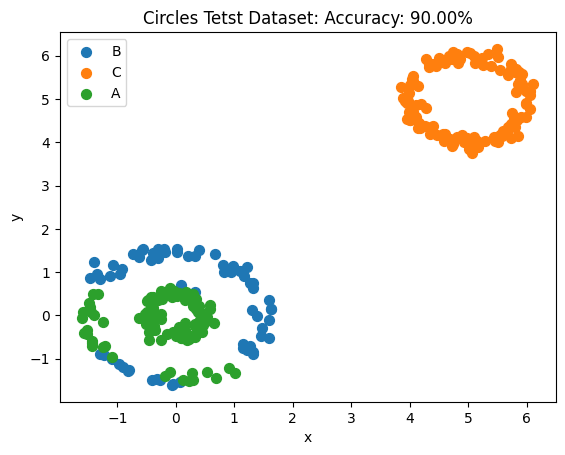

In [7]:
with no_grad():
    out = net(X_test)
    Y_pred = out.data.argmax(axis=1,keepdims=True).flatten()
    Y_data = Y_test.data.flatten()
    acc = np.mean(Y_pred == Y_data)

y_pred_labels = [id2labels[y] for y in Y_pred]
df_test['pred_labels'] = y_pred_labels


for label in df_test['pred_labels'].unique():
    x = df_test[df_test['pred_labels'] == label]['x']
    y = df_test[df_test['pred_labels'] == label]['y']

    plt.scatter(x,y,s=50,label=label)

plt.title(f"Circles Tetst Dataset: Accuracy: {100*acc:.2f}%")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()



<Axes: >

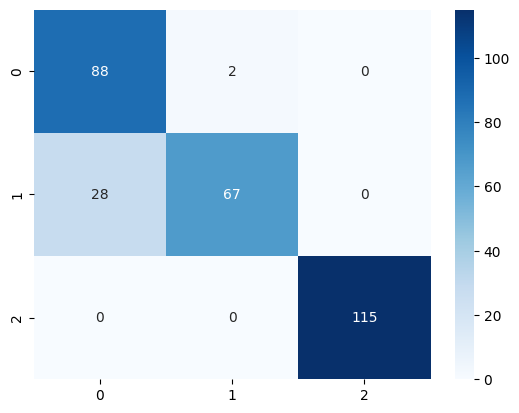

In [8]:
sns.heatmap(confusion_matrix(Y_data, Y_pred), annot=True, cmap="Blues", fmt=".0f")

In [9]:
print(classification_report(Y_data, Y_pred))

            precision   recall f1-score  support
0                0.76     0.98     0.85       90
1                0.97     0.71     0.82       95
2                1.00     1.00     1.00      115

accuracy                           0.90      300
macro avg        0.91     0.89     0.89      300
weighted avg     0.92     0.90     0.90      300


# Save and Load Model

In [10]:
joblib.dump(net, 'model.joblib')

['model.joblib']